# Imports

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, matthews_corrcoef
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score as gms
from sklearn.neural_network import MLPClassifier
from aux import *
import pandas as pd
pd.options.display.max_columns = 100

seed = 1997

scorer = matthews_corrcoef

# Lectura de datos

In [50]:
# Leemos la base de datos
col_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
for i in range(1,5):
    col_names.append('Wilderness_Area_' + str(i))
for i in range(1,41):
    col_names.append('Soil_Type_' + str(i))
col_names.append('Cover_Type')

dataset = pd.read_csv('covtype.data', header=None, names=col_names)

In [3]:
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [51]:
X = dataset.drop('Cover_Type', axis=1).sample(frac=1, random_state=seed)
y = dataset['Cover_Type'].sample(frac=1, random_state=seed)
y.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

# Train, test, val split

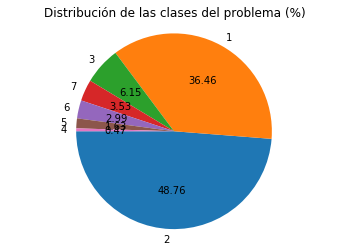

In [28]:
# Distribucion de las clases 
prop_class = y.value_counts(normalize=True)
pieLabels = ['2','1','3','7','6','5','4']
figureObject, axesObject = plt.subplots()
axesObject.pie(prop_class*100, labels=pieLabels, autopct='%1.2f', startangle=180)
axesObject.axis('equal')
plt.title("Distribución de las clases del problema (%)")
plt.show()

Separamos en train, vail y test.

Número de elementos de cada clase en `train`.

Undersampling

In [52]:
sizes = [3310, 4290, 3122, 440, 1028, 1518, 1792]
X_train = []
y_train = []
X_rest = []
y_rest = []
for i in range(1,8):
    elems = X[y == i]
    X_train.append(elems.iloc[:sizes[i-1]])
    y_train.append(y[y==i].iloc[:sizes[i-1]])
    X_rest.append(elems.iloc[sizes[i-1]:])
    y_rest.append(y[y==i].iloc[sizes[i-1]:])
    
X_train = pd.concat(X_train)
y_train = pd.concat(y_train)
X_rest = pd.concat(X_rest)
y_rest = pd.concat(y_rest)
print(X_rest.shape)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=15000, stratify=y_rest, random_state=seed)

(565512, 54)


In [53]:
print("Tamaño del conjunto de entrenamiento: ", X_train.shape[0])
print("Tamaño del conjunto de validacion: ", X_val.shape[0])
print("Tamaño del conjunto de test: ", X_test.shape[0])

Tamaño del conjunto de entrenamiento:  15500
Tamaño del conjunto de validacion:  15000
Tamaño del conjunto de test:  550512


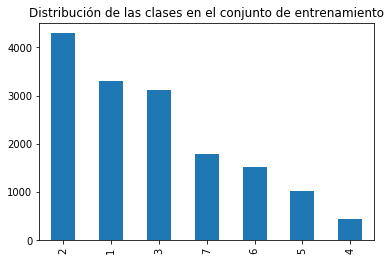

In [31]:
y_train.value_counts().plot(kind='bar', title='Distribución de las clases en el conjunto de entrenamiento');

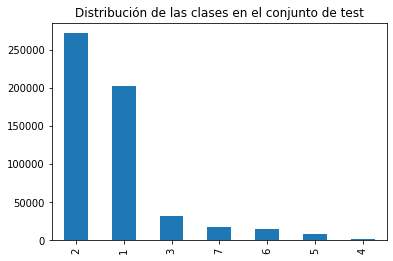

In [32]:
y_test.value_counts().plot(kind='bar', title='Distribución de las clases en el conjunto de test');

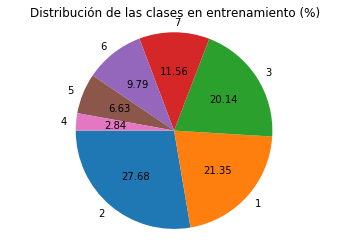

In [54]:
prop_class = y_train.value_counts(normalize=True)
pieLabels = ['2','1','3','7','6','5','4']
figureObject, axesObject = plt.subplots()
axesObject.pie(prop_class*100, labels=pieLabels, autopct='%1.2f', startangle=180)
axesObject.axis('equal')
plt.title("Distribución de las clases en entrenamiento (%)")
plt.show()

# Preprocesado

Definimos un `Pipeline` de preprocesado.

In [55]:
data_preprocess = Pipeline(
    [
        ("VT", VarianceThreshold()),
        ("Scaler", StandardScaler()),
    ]
)

Preprocesamos el conjunto de entrenamiento y mostramos la matriz de correlación antes y después.

In [56]:
X_train_new = data_preprocess.fit_transform(X_train)
print(X_train.shape)
print(X_train_new.shape)
# se eliminan los atributos Soil_Type_8 y Soil_Type_15 que tienen varianza 0

(15500, 54)
(15500, 52)


Matriz de correlación pre y post procesado (dígitos)


/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


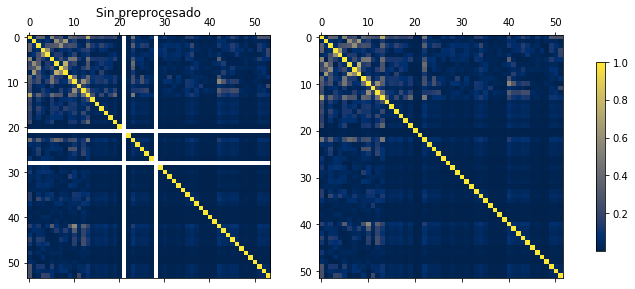

In [39]:
show_preprocess_correlation_matrix(X_train, X_train_new)

Preprocesamos validación y `test`.

In [60]:
X_train = X_train_new
X_val = data_preprocess.transform(X_val)
X_test = data_preprocess.transform(X_test)

# Modelos a considerar

Definimos un array con los modelos que vamos a considerar, se entrenarán y evaluarán en validación.

In [86]:
reg_values_lin = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
reg_values_svm = [1, 250, 500, 1000, 1250, 2000]

In [82]:
linear_models = []

linear_models += [
    (
        "Perceptron: C={}".format(c),
        SGDClassifier( loss='perceptron', alpha=c, class_weight='balanced', random_state=seed, n_jobs=-1
        ),
    )
    for c in reg_values_lin
]

linear_models += [
    (
        "Logistic regresion: C={}".format(c),
        SGDClassifier( loss='log', alpha=c, class_weight='balanced', random_state=seed, n_jobs=-1
        ),
    )
    for c in reg_values_lin
]

linear_models += [
    (
        "Linear SVM: C={}".format(c),
        SGDClassifier( loss='hinge', alpha=c, class_weight='balanced', random_state=seed, n_jobs=-1
        ),
    )
    for c in reg_values_lin
]

In [87]:
svm_models = []
svm_models += [
    (
        "SVM (poly): C={}".format(c),
        SVC(C=c, kernel='poly', class_weight='balanced', degree=3)
    )
    for c in reg_values_svm
]

svm_models += [
    (
        "SVM (rbf): C={}".format(c),
        SVC(C = c, class_weight='balanced', kernel='rbf')
    )
    for c in reg_values_svm
]

In [112]:
rf_models = []
rf_models += [
    (
        "Random Forest: {} estimators".format(n),
        RandomForestClassifier(n_estimators=n, class_weight="balanced", n_jobs=-1, 
                               random_state=seed)
    )
    for n in [100,250,500]
]
rf_models += [
    (
        "Random Forest: {} estimators, reduced number of samples".format(n),
        RandomForestClassifier(n_estimators=n, max_samples=10000, class_weight="balanced", 
                               n_jobs=-1, random_state=seed)
    )
    for n in [750, 1000]
]

In [93]:
hidden_layers = [60,80]
reg = [0.0001, 0.001, 0.01]
MLP_models = [
    (
        "Multilayer perceptron: hidden_layers = ({} {}), alpha = {}".format(a,b,c),
        MLPClassifier(alpha=c, hidden_layer_sizes=(a,b), random_state=seed)
    )
    for a in hidden_layers for b in hidden_layers for c in reg
]


# Elección de modelo

Hacemos `K-fold cross-validation` sobre cada uno de los conjuntos de modelos: lineal, knn y SVM. Y seleccionamos el mejor de cada uno.

In [83]:
best_linear = kfold_models(linear_models, X_train, y_train, seed, 
                           make_scorer(scorer), stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Perceptron: C=0.0001
	 Perceptron: C=0.0005
	 Perceptron: C=0.001
	 Perceptron: C=0.005
	 Perceptron: C=0.01
	 Perceptron: C=0.05
	 Perceptron: C=0.1
	 Perceptron: C=0.5
	 Perceptron: C=1
	 Logistic regresion: C=0.0001
	 Logistic regresion: C=0.0005
	 Logistic regresion: C=0.001
	 Logistic regresion: C=0.005
	 Logistic regresion: C=0.01
	 Logistic regresion: C=0.05
	 Logistic regresion: C=0.1
	 Logistic regresion: C=0.5
	 Logistic regresion: C=1
	 Linear SVM: C=0.0001
	 Linear SVM: C=0.0005
	 Linear SVM: C=0.001
	 Linear SVM: C=0.005
	 Linear SVM: C=0.01
	 Linear SVM: C=0.05
	 Linear SVM: C=0.1
	 Linear SVM: C=0.5
	 Linear SVM: C=1


--> Perceptron: C=0.0001 <--
Score en K-fold: 0.464


--> Perceptron: C=0.0005 <--
Score en K-fold: 0.463


--> Perceptron: C=0.001 <--
Score en K-fold: 0.478


--> Perceptron: C=0.005 <--
Score en K-fold: 0.477


--> Perceptron: C=0.01 <--
Score en K-fold: 0.476


--> Perceptron: C=0.05 <--
Score en K-fold: 0.48

In [110]:
best_svm = kfold_models(svm_models, X_train, y_train, seed, make_scorer(scorer),
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 SVM (rbf): C=1
	 SVM (rbf): C=250
	 SVM (rbf): C=500
	 SVM (rbf): C=1000
	 SVM (rbf): C=1250
	 SVM (rbf): C=2000


--> SVM (rbf): C=1 <--
Score en K-fold: 0.603


--> SVM (rbf): C=250 <--
Score en K-fold: 0.736


--> SVM (rbf): C=500 <--
Score en K-fold: 0.744


--> SVM (rbf): C=1000 <--
Score en K-fold: 0.749


--> SVM (rbf): C=1250 <--
Score en K-fold: 0.751


--> SVM (rbf): C=2000 <--
Score en K-fold: 0.750



Mejor modelo: SVC(C=1250, class_weight='balanced')


In [113]:
best_rf = kfold_models(rf_models, X_train, y_train, seed, make_scorer(scorer),
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Random Forest: 100 estimators
	 Random Forest: 250 estimators
	 Random Forest: 500 estimators
	 Random Forest: 750 estimators, reduced number of samples
	 Random Forest: 1000 estimators, reduced number of samples


--> Random Forest: 100 estimators <--
Score en K-fold: 0.798


--> Random Forest: 250 estimators <--
Score en K-fold: 0.798


--> Random Forest: 500 estimators <--


/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Score en K-fold: 0.799


--> Random Forest: 750 estimators, reduced number of samples <--
Score en K-fold: 0.794


--> Random Forest: 1000 estimators, reduced number of samples <--


/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Score en K-fold: 0.795



Mejor modelo: RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=1997)


In [94]:
best_MLP = kfold_models(MLP_models, X_train, y_train, seed, make_scorer(scorer),
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Multilayer perceptron: hidden_layers = (60 60), alpha = 0.0001
	 Multilayer perceptron: hidden_layers = (60 60), alpha = 0.001
	 Multilayer perceptron: hidden_layers = (60 60), alpha = 0.01
	 Multilayer perceptron: hidden_layers = (60 80), alpha = 0.0001
	 Multilayer perceptron: hidden_layers = (60 80), alpha = 0.001
	 Multilayer perceptron: hidden_layers = (60 80), alpha = 0.01
	 Multilayer perceptron: hidden_layers = (80 60), alpha = 0.0001
	 Multilayer perceptron: hidden_layers = (80 60), alpha = 0.001
	 Multilayer perceptron: hidden_layers = (80 60), alpha = 0.01
	 Multilayer perceptron: hidden_layers = (80 80), alpha = 0.0001
	 Multilayer perceptron: hidden_layers = (80 80), alpha = 0.001
	 Multilayer perceptron: hidden_layers = (80 80), alpha = 0.01


--> Multilayer perceptron: hidden_layers = (60 60), alpha = 0.0001 <--
Score en K-fold: 0.758


--> Multilayer perceptron: hidden_layers = (60 60), alpha = 0.001 <--
Score en K-fold: 0.756

Entrenamos y evaluamos cada modelo en el conjunto de validación, quedandonos con el mejor de ellos en `best_model`.

In [33]:
best_model = 0
best_model_score = 0

models = [best_linear, best_svm, best_rf, best_balanced_rf, best_MLP]

for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    val_score =  scorer(y_val, y_pred)
    print("Validation Score: ", val_score)
    if best_model_score < val_score:
        best_model_score = val_score
        best_model = model

LogisticRegression(C=1000, class_weight='balanced', max_iter=1500,
                   multi_class='ovr', n_jobs=-1, random_state=1997,
                   solver='saga')


/home/ludvins/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Validation Score:  0.4372658210643253
SVC(C=1250, class_weight='balanced')
Validation Score:  0.6389693599889061
RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=1997)
Validation Score:  0.716525317860378
BalancedRandomForestClassifier(class_weight='balanced', n_estimators=500,
                               n_jobs=-1, random_state=1997,
                               sampling_strategy='not minority')
Validation Score:  0.5517136912459372
MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 75), random_state=1997)
Validation Score:  0.6692930836706882


/home/ludvins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


El mejor modelo ha resultado:

In [34]:
print(best_model)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=1997)


# Predicción

Predecimos los valores de `test` con dicho modelo.

In [35]:
y_pred = best_model.predict(X_test)
print("Score obtenido: {:.2f}".format(scorer(y_test, y_pred)))

Score obtenido: 0.71


Mostramos la curva de aprendizaje obtenida por el modelo de la siguiente forma, empezamos tomando el $10\%$ del conjunto de `train` y hacemos `cross-validation` con dicho conjunto, repetimos el proceso aumentando el porcentage del conjunto utilizado hasta llegar al $100\%$.

/home/ludvins/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ludvins/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ludvins/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ludvins/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ludvins/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ludvins/.

<module 'matplotlib.pyplot' from '/usr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

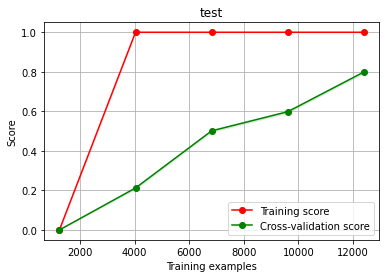

In [36]:
plot_learning_curve(best_model, "test", X_train, y_train, scoring = make_scorer(scorer), )

Mostramos la matriz de confusión de los datos

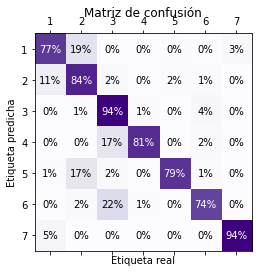

In [37]:
"""Muestra matriz de confusión de la base de datos de dígitos."""
show_confusion_matrix(y_test, y_pred, 7)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.77      0.81    202999
           2       0.85      0.84      0.84    271610
           3       0.75      0.94      0.83     31766
           4       0.81      0.81      0.81      2246
           5       0.53      0.79      0.63      8240
           6       0.67      0.74      0.70     15429
           7       0.69      0.94      0.80     18222

    accuracy                           0.82    550512
   macro avg       0.73      0.83      0.78    550512
weighted avg       0.83      0.82      0.82    550512

